In [12]:
# CAP6629 001 RL Spring 2023
# Yiran Pang
# Copied and adapted from https://www.samyzaf.com/ML/rl/qmaze.html about Maze Definition Part

In [13]:
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- 0 - 左
- 1 - 向上
- 2 - 右
- 3 - 向下
- 每次移动都会花费老鼠 -0.04 分
- 奶酪，给予 1.0 分
- 封锁的单元格-0.75 分，动作不会被执行
- 已经访问过的单元格，-0.25 分
- 总奖励低于负阈值：(-0.5 * maze.size)，lose

In [14]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

## Q-maze

In [15]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        # 初始化迷宫，老鼠可以从任意位置开始，默认为左上角
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        # 终点始终在右下角
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        # 初始化空格list，maze为1表示空格，为0表示墙体
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        # 将目标格移出空格list
        self.free_cells.remove(self.target)
        # 检查左上和右下是否为空
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        # 放置老鼠并初始化参数
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        # 初始状态
        self.state = (row, col, 'start')
        # 设置最低奖励阈值
        self.min_reward = -0.5 * self.maze.size
        # 初始化总奖励
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        '''
            input: action [0, 1, 2, 3] [L, U, R, D]
        '''
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state
        
        # 如果老鼠访问的是空格，则记录
        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        # 获取所有可能执行的动作
        valid_actions = self.valid_actions()
        # print('valid_actions', valid_actions)
        
        # 如果没有可以执行的动作（被围住了），则状态为 blocked，位置不变
        if not valid_actions:
            nmode = 'blocked'
        # 如果需要执行的动作在可执行动作列表中，那么状态为有效，并相应执行动作
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        # 如果需要执行的动作不在可执行动作列表中（撞墙），位置不变
        else:                  # invalid action, no change in rat position
            nmode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0  # 奶酪，给予 1.0 分
        if mode == 'blocked':
            return self.min_reward - 1
        # if (rat_row, rat_col) in self.visited:
        #     return -0.25  # 访问已经访问过的单元格，-0.25 分
        if mode == 'invalid':
            return -0.75  # 撞墙-0.75 分，动作不会被执行
        if mode == 'valid':
            return -0.04  # 每次移动都会花费老鼠 -0.04 分

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        # 默认验证当前位置
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        # 如果在第0行，则不能向上走；如果在最后一行，则不能向下走
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)
        # 列-左右
        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        # 如果不在最左列，而左边是墙，则不能向左；右边同理
        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        # 上下同理
        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        # 返回所有可能执行的动作
        return actions

In [16]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [17]:
maze = [
    [ 1.,  1., 1.],
    [ 1.,  1., 1.],
    [ 1.,  1., 1.],
]

reward= -0.04


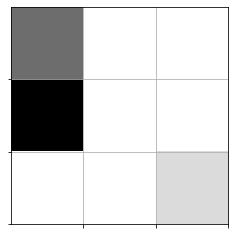

In [76]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

-0.04 -0.08
-0.04 -0.12
1.0 0.88 win


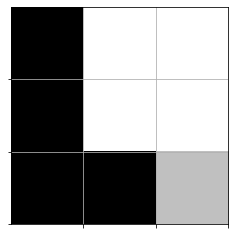

In [77]:
envstate, reward, status = qmaze.act(DOWN)  # move down
print(reward, qmaze.total_reward)
envstate, reward, status = qmaze.act(RIGHT)  # move right
print(reward, qmaze.total_reward)
envstate, reward, status = qmaze.act(RIGHT)  # move right
print(reward, qmaze.total_reward, status)
# envstate, reward, status = qmaze.act(RIGHT)  # move right
# print(reward, qmaze.total_reward)
# envstate, reward, status = qmaze.act(UP)  # move up
# print(reward, qmaze.total_reward)
show(qmaze)

## Q-Learning

0 - 左
1 - 向上
2 - 右
3 - 向下

$$Q(s,a)= Q(s, a) + α⋅[Value(s’)+γ⋅maxQ(s′)−Q(s,a)]$$

**Pseudocode**
```
Init Q(s, a) to 0 for all (s, a) pairs
Repeat for episode = 1 ... numEpisodes
     Initialize s to startState
     While (s is not TerminalState)
           Choose an action a from Actions(s)
           s' = new state after action a from s
           Q(s,a)= Q(s, a) + α⋅[Value(s’)+γ⋅maxQ(s′)−Q(s,a)]
           s = s'
```

In [482]:
# 定义参数
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99
NUM_Episodes = 10
MAZE_SIZE = qmaze.maze.shape[0]

# 将状态表示为一个数字
def state_to_index(state):
    return state[0] * MAZE_SIZE + state[1]

# 获取当前状态下的最佳行动
def get_best_action(rat_row, rat_col):
    state = (rat_row, rat_col)
    index = state_to_index(state)
    return np.argmax(q_table[index])

# 通过ε-greedy策略选择下一个行动
def choose_action(state, epsilon):
    if np.random.uniform() < epsilon:
        return np.random.randint(4)
    else:
        return get_best_action(*state)
    
# 更新 Q 表格
def update_q_table(state, action, next_state, reward):
    index = state_to_index(state)
    next_index = state_to_index(next_state)
    q_table[index][action] += LEARNING_RATE * (
        reward + DISCOUNT_FACTOR * np.max(q_table[next_index]) - q_table[index][action])

    
# Q-Table
# 每行代表格子，从上往下从左往右
# 每列代表动作，0 - 左 1 - 向上 2 - 右 3 - 向下
q_table = np.zeros((qmaze.maze.shape[0]**2, 4))  
total_reward = []

for episode in range(NUM_Episodes):
    epsilon = 1.0 / (episode + 1)
    
    qmaze = Qmaze(maze)
    
    while qmaze.game_status() == 'not_over':
        # 初次观测
        rat_row, rat_col, mode = qmaze.state
        # 选择动作
        # print(rat_row, rat_col, mode)
        action = choose_action((rat_row, rat_col), epsilon)
        # print(action)
        # 执行动作并二次观测
        canvas, reward, game_over = qmaze.act(action)
        rat_row_next, rat_col_next, mode = qmaze.state
        # 根据观测更新Q
        update_q_table((rat_row, rat_col), action, (rat_row_next, rat_col_next), reward)
    
    print('============episode:', episode, '============')
    print(q_table)
    print('total_reward', qmaze.total_reward)
    total_reward.append(qmaze.total_reward)
    print('')

============episode: 0 ============
[[-0.075      -0.35141925  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
total_reward -5.25

============episode: 1 ============
[[-0.075      -0.35141925 -0.0076     -0.004     ]
 [-0.004396   -0.075      -0.004      -0.0076    ]
 [-0.004       0.          0.          0.        ]
 [ 0.         -0.004      -0.004       0.        ]
 [-0.004      -0.004      -0.004       0.        ]
 [ 0.          0.          0.          0.1       ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0

In [483]:
q_value_table = np.amax(q_table, axis=1).reshape((3, 3))
print('q_value_table')
print(q_value_table)

q_value_table
[[-0.02407929 -0.00791055  0.02012   ]
 [-0.0131719   0.07338479  0.271     ]
 [ 0.0232061   0.468559    0.        ]]


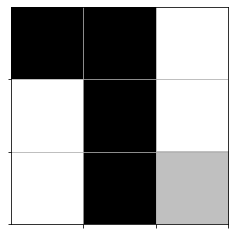

In [484]:
show(qmaze)

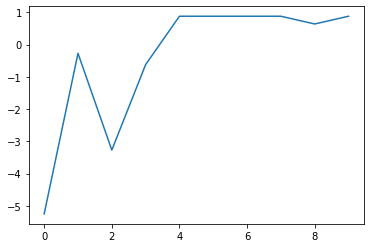

In [485]:
%matplotlib inline
plt.plot(total_reward)
plt.show()

## Monte Carlo

**Pseudocode**
```
Initialize state-action value function Q(s, a)
Initialize sampling counter N(s, a)
for episode in episodes:
    Generate an episode and record information for each state-action pair
    G = 0
    for t in reversed(range(0, episode_length)):
        S_t, A_t, R_t = episode[t]
        G = gamma * G + R_t
        N(S_t, A_t) += 1
        alpha = 1 / N(S_t, A_t)
        Q(S_t, A_t) += alpha * (G - Q(S_t, A_t))
return state-action value function Q
```

In [101]:
from tqdm import trange

# 定义参数
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99
NUM_Episodes = 10
MAZE_SIZE = qmaze.maze.shape[0]
records = []
q_table = np.zeros((qmaze.maze.shape[0]**2, 4))  

# 将状态表示为一个数字
def state_to_index(state):
    return state[0] * MAZE_SIZE + state[1]

# 获取当前状态下的最佳行动
def get_best_action(rat_row, rat_col):
    state = (rat_row, rat_col)
    index = state_to_index(state)
    return np.argmax(q_table[index])

# 通过ε-greedy策略选择下一个行动
def choose_action(state, epsilon):
    if np.random.uniform() < epsilon:
        return np.random.randint(4)
    else:
        return get_best_action(*state)
    
# 更新 Q 表格
# def update_q_table(state, action, next_state, reward):
#     index = state_to_index(state)
#     next_index = state_to_index(next_state)
#     q_table[index][action] += LEARNING_RATE * (
#         reward + DISCOUNT_FACTOR * np.max(q_table[next_index]) - q_table[index][action])

    
# Q-Table
# 每行代表格子，从上往下从左往右
# 每列代表动作，0 - 左 1 - 向上 2 - 右 3 - 向下
Q = q_table  # 初始化状态-动作价值函数
N = np.zeros((qmaze.maze.shape[0]**2, 4))  # 记录每个状态-动作被采样的次数
total_reward = []

for episode in trange(NUM_Episodes):
    epsilon = 0.1
    
    qmaze = Qmaze(maze)
    
    # 进行一次完整的 episode，并记录每个状态-动作的信息
    while qmaze.game_status() == 'not_over':
        # 初次观测
        rat_row, rat_col, mode = qmaze.state
        # 选择动作
        # print(rat_row, rat_col, mode)
        action = choose_action((rat_row, rat_col), epsilon)

        state, action = state_to_index((rat_row, rat_col)), action

        # 执行动作并二次观测
        canvas, reward, game_over = qmaze.act(action)

        records.append((state, action, reward))

        rat_row_next, rat_col_next, mode = qmaze.state
        

    
    # 使用经验采样更新状态-动作价值函数
    G = 0  # 记录返回值
    for j in range(len(records)-1, -1, -1):
        state, action, reward = records[j]
        G += reward
        N[state][action] += 1
        alpha = 1 / N[state][action]
        Q[state][action] += alpha * (G - Q[state][action])
        
    # # 根据观测更新Q
    # update_q_table((rat_row, rat_col), action, (rat_row_next, rat_col_next), reward)
    
    # print('============episode:', episode, '============')
    # print(Q)
    # print('total_reward', qmaze.total_reward)
    total_reward.append(qmaze.total_reward)
    # print('')
    
    # break

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.72it/s]


In [102]:
q_value_table = np.amax(Q, axis=1).reshape((3, 3))
print('q_value_table')
print(q_value_table)

q_value_table
[[-12.20965116 -10.07315789   0.        ]
 [ -6.316       -2.57273973   0.        ]
 [  0.           1.29333333   0.        ]]


In [103]:
# print('q_value_table')
# Q = np.array([[0.49107692, 2.30230769, 1.733     ], [2.0725     ,4.33777778  , 2.938       ], [ 0., 4.29777778  , 0.]])

In [104]:
Q 

array([[-20.9964486 , -19.46916667, -17.24666667, -12.20965116],
       [-17.30928571, -15.28842105, -15.55846154, -10.07315789],
       [-18.505     ,  -8.865     ,  -0.62      ,   0.        ],
       [-14.53395833, -12.48782051,  -6.316     , -14.01666667],
       [-12.18666667,  -9.71666667,  -6.94767442,  -2.57273973],
       [ -7.32      ,  -1.41      ,   0.        ,   0.        ],
       [ -5.34      , -13.97666667,   0.        ,   0.        ],
       [ -6.88      ,  -2.44318182,   1.29333333,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ]])

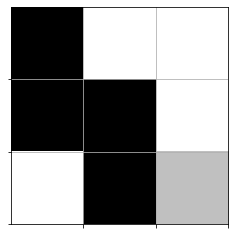

In [105]:
show(qmaze)

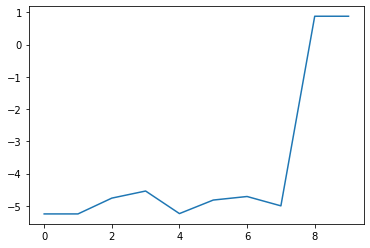

In [106]:
%matplotlib inline
plt.plot(total_reward)
plt.show()

In [527]:
qmaze = Qmaze(maze)
records = []  # state, action, reward

# 进行一次完整的 episode，并记录每个状态-动作的信息
while qmaze.game_status() == 'not_over':
    # 初次观测
    rat_row, rat_col, mode = qmaze.state
    # 选择动作
    # print(rat_row, rat_col, mode)
    action = choose_action((rat_row, rat_col), epsilon)
    
    state, action = state_to_index((rat_row, rat_col)), action
    
    # 执行动作并二次观测
    canvas, reward, game_over = qmaze.act(action)
    
    records.append((state, action, reward))
    
    rat_row_next, rat_col_next, mode = qmaze.state

In [528]:
records

[(0, 0, -0.75), (0, 3, -0.04), (3, 2, -0.04), (4, 3, -0.04), (7, 2, 1.0)]

7812117768267714106

In [488]:
qmaze.canvas

AttributeError: 'Qmaze' object has no attribute 'canvas'

In [ ]:
import random

def run_maze():
    env = MazeEnv(maze_size=3)
    num_episodes = 10000
    Q = np.zeros((env.maze_size, env.maze_size, 4))  # 初始化状态-动作价值函数
    N = np.zeros((env.maze_size, env.maze_size, 4))  # 记录每个状态-动作被采样的次数

    for i in range(num_episodes):
        episode = []
        state = env.reset()

        # 进行一次完整的 episode，并记录每个状态-动作的信息
        done = False
        while not done:
            action = choose_action(state, Q)
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # 使用经验采样更新状态-动作价值函数
        G = 0  # 记录返回值
        for j in range(len(episode)-1, -1, -1):
            state, action, reward = episode[j]
            G += reward
            N[state][action] += 1
            alpha = 1 / N[state][action]
            Q[state][action] += alpha * (G - Q[state][action])

    # 输出最终的状态-动作价值函数
    print("Final Q:")
    print(Q)

def choose_action(state, Q, eps=0.1):
    if random.random() < eps:
        return random.randint(0, 3)
    else:
        return np.argmax(Q[state])


## backup

In [13]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False
        
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [15]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [ ]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [ ]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Qmaze(maze)
show(qmaze)

In [ ]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)